/var/folders/nw/k_k0_cbj7vl_npdmryvhl53c0000gn/T/ipykernel_94231/425452617.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2023-01-01", periods=n_days*24, freq=freq)


Train windows: (6061, 48, 7)  Val: (1243, 48, 7)  Test: (1243, 48, 7)

== Test-Metriken (voller Testzeitraum) ==
        Naiv  |  MAE=3.627  RMSE=6.416  sMAPE=15.98%  MASE=2.106
      S-Naiv  |  MAE=3.801  RMSE=6.553  sMAPE=16.57%  MASE=2.208
       Ridge  |  MAE=2.096  RMSE=5.786  sMAPE=10.79%  MASE=1.217
        LSTM  |  MAE=2.514  RMSE=5.918  sMAPE=12.20%  MASE=1.460
         TCN  |  MAE=2.129  RMSE=5.794  sMAPE=10.90%  MASE=1.236


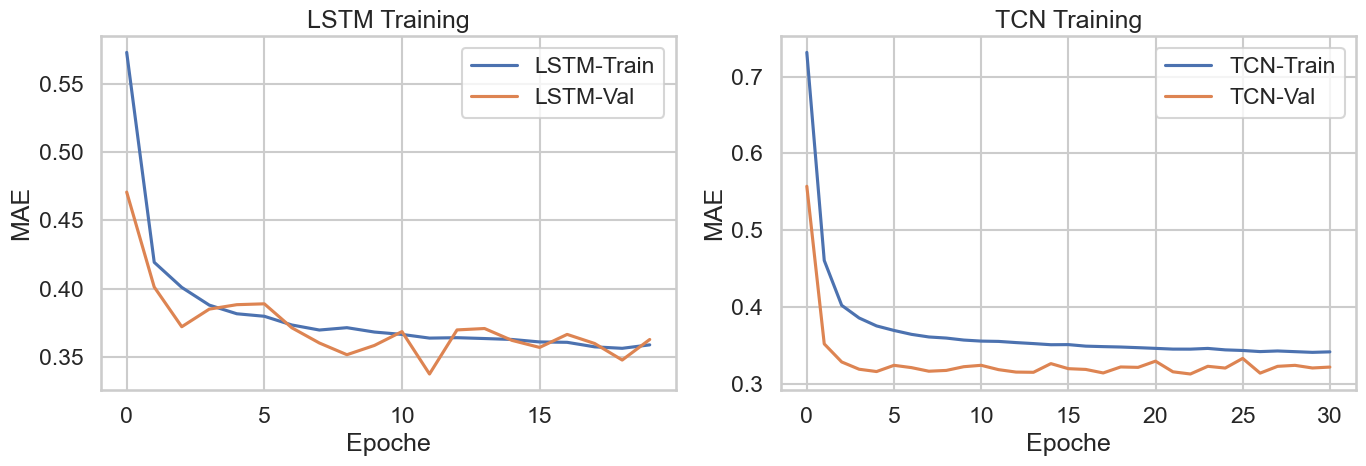

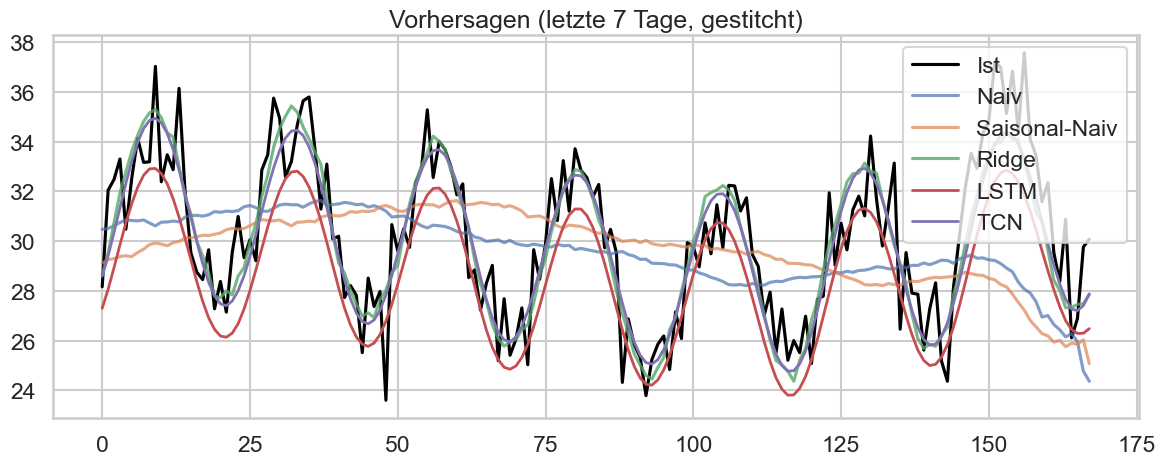


Fertig: Baselines, LSTM und TCN verglichen; sauberes Fenster-Setup, zeitliche Splits, robuste Metriken und Visualisierungen.


In [4]:
"""
Vorlesung 9 – LSTM & ML-Zeitreihen (ein einziges, kommentiertes Snippet)

Was passiert:
1) Wir erzeugen eine stündliche Zeitreihe (1 Jahr) mit Trend + täglicher & wöchentlicher Saisonalität,
   exogenen Variablen (Temperatur-ähnlich, "Promo"-Dummy) und Rauschen.
2) Wir splitten zeitlich in Train/Val/Test, skalieren NUR auf Train.
3) Wir bauen Fenster (W=48 Stunden) und sagen H=24 Stunden voraus (Sequence-to-Many, Multi-Output).
4) Baselines: Naiv, Saisonal-Naiv (s=24), Ridge (Multi-Output auf Lags).
5) Deep-Modelle: LSTM (einfach) und 1D-CNN mit dilatierten, kausalen Convs (TCN-artig).
6) Metriken: MAE, RMSE, sMAPE, MASE. Plots: Trainingskurven, Vorhersage vs. Ist (gestitcht), Vergleich.
Benötigt: numpy, pandas, seaborn, matplotlib, scikit-learn, tensorflow (keras)
"""

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

sns.set_theme(style="whitegrid", context="talk")
np.random.seed(7); tf.random.set_seed(7)

# ------------------------------------------------------------
# 0) Daten erzeugen: 1 Jahr stündlich
# ------------------------------------------------------------
n_days = 365
freq = "H"
idx = pd.date_range("2023-01-01", periods=n_days*24, freq=freq)
t = np.arange(len(idx))

# Ziel y: Trend + Daily + Weekly + Exo + Rauschen
trend = 0.0008 * t                       # langsamer Aufwärtstrend
daily = 3.0 * np.sin(2*np.pi*t/24)       # tägliche Saison
weekly = 1.5 * np.sin(2*np.pi*t/(24*7))  # wöchentliche Saison
temp = 10 + 8*np.sin(2*np.pi*(t-6)/24) + np.random.normal(0, 1.5, len(t))  # exogen (Temperatur-ähnlich)
promo = ( (t % (24*14)) < 24 ).astype(float)  # "Promo" 1x pro 14 Tage für 24h

noise = np.random.normal(0, 1.2, len(t))
y = 20 + trend + daily + weekly + 0.3*temp + 2.0*promo + noise

df = pd.DataFrame({"y": y, "temp": temp, "promo": promo}, index=idx)
# Kalender-Features (Fourier / Sinus-Cosinus)
hr = np.arange(len(idx)) % 24
dw = (np.arange(len(idx)) // 24) % 7
df["sin_hr"] = np.sin(2*np.pi*hr/24); df["cos_hr"] = np.cos(2*np.pi*hr/24)
df["sin_wd"] = np.sin(2*np.pi*dw/7);  df["cos_wd"] = np.cos(2*np.pi*dw/7)

# ------------------------------------------------------------
# 1) Zeitlicher Split + Skalierung (nur auf Train fitten)
# ------------------------------------------------------------
N = len(df)
train_end = int(N*0.7)
val_end   = int(N*0.85)
df_train, df_val, df_test = df.iloc[:train_end], df.iloc[train_end:val_end], df.iloc[val_end:]

feature_cols = ["y","temp","promo","sin_hr","cos_hr","sin_wd","cos_wd"]  # y-Vergangenheit als Feature
Xsc = StandardScaler().fit(df_train[feature_cols])
ysc = StandardScaler().fit(df_train[["y"]])  # Ziel separat skalieren

def scale_block(block):
    X = Xsc.transform(block[feature_cols])
    y = ysc.transform(block[["y"]])
    return X, y

Xtr_s, ytr_s = scale_block(df_train)
Xva_s, yva_s = scale_block(df_val)
Xte_s, yte_s = scale_block(df_test)

# ------------------------------------------------------------
# 2) Fenster bauen: W=48, H=24 (Sequence-to-Many)
# ------------------------------------------------------------
W, H = 48, 24

def make_windows(X_s, y_s, W, H):
    Xs, Ys = [], []
    for t0 in range(W, len(X_s)-H+1):
        Xs.append(X_s[t0-W:t0, :])
        Ys.append(y_s[t0:t0+H, 0])   # nur Zielspalte
    Xs = np.array(Xs, dtype=np.float32)
    Ys = np.array(Ys, dtype=np.float32)
    return Xs, Ys

Xtr_win, Ytr = make_windows(Xtr_s, ytr_s, W, H)
Xva_win, Yva = make_windows(Xva_s, yva_s, W, H)
Xte_win, Yte = make_windows(Xte_s, yte_s, W, H)

print(f"Train windows: {Xtr_win.shape}  Val: {Xva_win.shape}  Test: {Xte_win.shape}")

# ------------------------------------------------------------
# 3) Baselines: Naiv, Saisonal-Naiv, Ridge (Multi-Output)
# ------------------------------------------------------------
def baseline_naive(X_win):
    # nimmt letzte bekannte y (skaliert) im Fenster und kopiert sie für H Schritte
    last_y = X_win[:, -1, 0]  # Spalte 0 = y (skaliert)
    return np.tile(last_y[:, None], (1, H))

def baseline_seasonal_naive(X_win, period=24):
    # nimmt Wert aus gleicher Stunde des Vortags im Fenster
    # im Fenster sind W Schritte: Index -period
    idx = -period
    base = X_win[:, idx, 0]
    return np.tile(base[:, None], (1, H))

Y_pred_naive_s   = baseline_naive(Xte_win)
Y_pred_snaive_s  = baseline_seasonal_naive(Xte_win, 24)

# Ridge (Tabular-Lags): flache Features bauen
def flatten_windows(X_win):
    n, w, f = X_win.shape
    return X_win.reshape(n, w*f)

Xtr_flat = flatten_windows(Xtr_win)
Xva_flat = flatten_windows(Xva_win)
Xte_flat = flatten_windows(Xte_win)

ridge = MultiOutputRegressor(Ridge(alpha=1.0, random_state=7)).fit(Xtr_flat, Ytr)
Y_pred_ridge_s = ridge.predict(Xte_flat)

# ------------------------------------------------------------
# 4) LSTM-Modell (Sequence-to-Many, Multi-Output)
# ------------------------------------------------------------
def build_lstm(n_feat, H):
    model = models.Sequential([
        layers.Input(shape=(W, n_feat)),
        layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.0),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(H)
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mae")
    return model

lstm = build_lstm(Xtr_win.shape[-1], H)
cb = [callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
hist_lstm = lstm.fit(Xtr_win, Ytr, validation_data=(Xva_win, Yva),
                     epochs=50, batch_size=64, callbacks=cb, verbose=0)

Y_pred_lstm_s = lstm.predict(Xte_win, verbose=0)

# ------------------------------------------------------------
# 5) 1D-CNN (TCN-artig): dilatierte, kausale Convs
# ------------------------------------------------------------
def build_tcn(n_feat, H):
    inp = layers.Input(shape=(W, n_feat))
    x = inp
    for d in [1, 2, 4, 8]:
        x = layers.Conv1D(filters=32, kernel_size=3, dilation_rate=d,
                          padding="causal", activation="relu")(x)
        x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(H)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mae")
    return model

tcn = build_tcn(Xtr_win.shape[-1], H)
hist_tcn = tcn.fit(Xtr_win, Ytr, validation_data=(Xva_win, Yva),
                   epochs=50, batch_size=64, callbacks=cb, verbose=0)

Y_pred_tcn_s = tcn.predict(Xte_win, verbose=0)

# ------------------------------------------------------------
# 6) Rückskalieren & "Stitching" der Multi-Output-Vorhersagen auf die Zeitachse
# ------------------------------------------------------------
def inverse_scale_targets(Y_pred_scaled):
    # Y_pred_scaled: (n_samples, H) in Standard-Scaler-Skala der y
    # Invers: y_hat = Y * sigma + mu  (Scaler über Spalte y)
    mu = ysc.mean_[0]; sigma = ysc.scale_[0]
    return Y_pred_scaled * sigma + mu

Yte_inv      = inverse_scale_targets(Yte)
Yhat_naive   = inverse_scale_targets(Y_pred_naive_s)
Yhat_snaive  = inverse_scale_targets(Y_pred_snaive_s)
Yhat_ridge   = inverse_scale_targets(Y_pred_ridge_s)
Yhat_lstm    = inverse_scale_targets(Y_pred_lstm_s)
Yhat_tcn     = inverse_scale_targets(Y_pred_tcn_s)

# Stitch: wir legen die H-Schritte Fenster für Fenster auf die Testzeit und mitteln Überdeckungen
T_test = len(df_test)
start = W  # erstes Ziel im jeweiligen Block (innerhalb des Test-Blocks)
def stitch(preds, H, total_len):
    agg = np.zeros(total_len); cnt = np.zeros(total_len)
    # Testfenster beginnen bei Indizes: W .. len(test)-H
    for i in range(len(preds)):
        t0 = i + W  # Position im skalierten Testblock
        for h in range(H):
            if t0 + h < total_len:
                agg[t0 + h] += preds[i, h]; cnt[t0 + h] += 1
    cnt[cnt == 0] = 1
    return agg / cnt

# Achtung: Unsere Test-Fenster beziehen sich auf df_test skaliert -> Länge len(yte_s)
total_len = len(yte_s)
y_true_full = df_test["y"].values  # Originalskala

yhat_naive_series  = stitch(Yhat_naive,  H, total_len)
yhat_snaive_series = stitch(Yhat_snaive, H, total_len)
yhat_ridge_series  = stitch(Yhat_ridge,  H, total_len)
yhat_lstm_series   = stitch(Yhat_lstm,   H, total_len)
yhat_tcn_series    = stitch(Yhat_tcn,    H, total_len)

# ------------------------------------------------------------
# 7) Metriken (über volle Testperiode)
# ------------------------------------------------------------
def smape(y_true, y_pred, eps=1e-8):
    return 200.0 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + eps))

def mase(y_true, y_pred, y_train, season=24, eps=1e-8):
    # Skala = mittlerer absoluter Fehler einer saisonal-naiven Prognose auf dem TRAIN
    naive_train = np.abs(y_train[season:] - y_train[:-season]).mean()
    return np.mean(np.abs(y_true - y_pred)) / (naive_train + eps)

y_train_orig = df_train["y"].values  # für MASE-Skala

def report(name, y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    s = smape(y_true, y_hat)
    m = mase(y_true, y_hat, y_train_orig, season=24)
    print(f"{name:>12s}  |  MAE={mae:.3f}  RMSE={rmse:.3f}  sMAPE={s:.2f}%  MASE={m:.3f}")

print("\n== Test-Metriken (voller Testzeitraum) ==")
report("Naiv",   y_true_full, yhat_naive_series)
report("S-Naiv", y_true_full, yhat_snaive_series)
report("Ridge",  y_true_full, yhat_ridge_series)
report("LSTM",   y_true_full, yhat_lstm_series)
report("TCN",    y_true_full, yhat_tcn_series)

# ------------------------------------------------------------
# 8) Plots: Trainingsverlauf & Vorhersage vs. Ist (letzte 7 Tage)
# ------------------------------------------------------------
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(hist_lstm.history["loss"], label="LSTM-Train")
ax[0].plot(hist_lstm.history["val_loss"], label="LSTM-Val")
ax[0].set_title("LSTM Training"); ax[0].set_xlabel("Epoche"); ax[0].set_ylabel("MAE"); ax[0].legend()

ax[1].plot(hist_tcn.history["loss"], label="TCN-Train")
ax[1].plot(hist_tcn.history["val_loss"], label="TCN-Val")
ax[1].set_title("TCN Training"); ax[1].set_xlabel("Epoche"); ax[1].set_ylabel("MAE"); ax[1].legend()
plt.tight_layout(); plt.show()

# Letzte 7 Tage visualisieren
last_hours = 24*7
y_plot = y_true_full[-last_hours:]
plt.figure(figsize=(12,5))
plt.plot(y_plot, label="Ist", color="black")
plt.plot(yhat_naive_series[-last_hours:],  label="Naiv", alpha=0.7)
plt.plot(yhat_snaive_series[-last_hours:], label="Saisonal-Naiv", alpha=0.7)
plt.plot(yhat_ridge_series[-last_hours:],  label="Ridge", alpha=0.8)
plt.plot(yhat_lstm_series[-last_hours:],   label="LSTM", linewidth=2)
plt.plot(yhat_tcn_series[-last_hours:],    label="TCN", linewidth=2)
plt.title("Vorhersagen (letzte 7 Tage, gestitcht)")
plt.legend(); plt.tight_layout(); plt.show()

print("\nFertig: Baselines, LSTM und TCN verglichen; sauberes Fenster-Setup, zeitliche Splits, robuste Metriken und Visualisierungen.")
